In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

### Question 1a

In [2]:
def kernel_function(x, j, p, q): 
    return (
        np.exp(j * p * x) *
        np.cos(2 * np.pi * j * q * x)
    )

#### build a mesh

In [3]:
n_cells = 100 
n_nodes = n_cells + 1
x_nodes = np.linspace(0, 1, n_nodes) #domain

In [4]:
#define initial parameters for p, q, j
p = -0.05
q = 0.1
j = 30 

#changing for p, q, j
p_values = [-0.05, 0.00, 0.05]
q_values = [0.1, 0.5, 1]
j_values = [1, 2.5, 5]

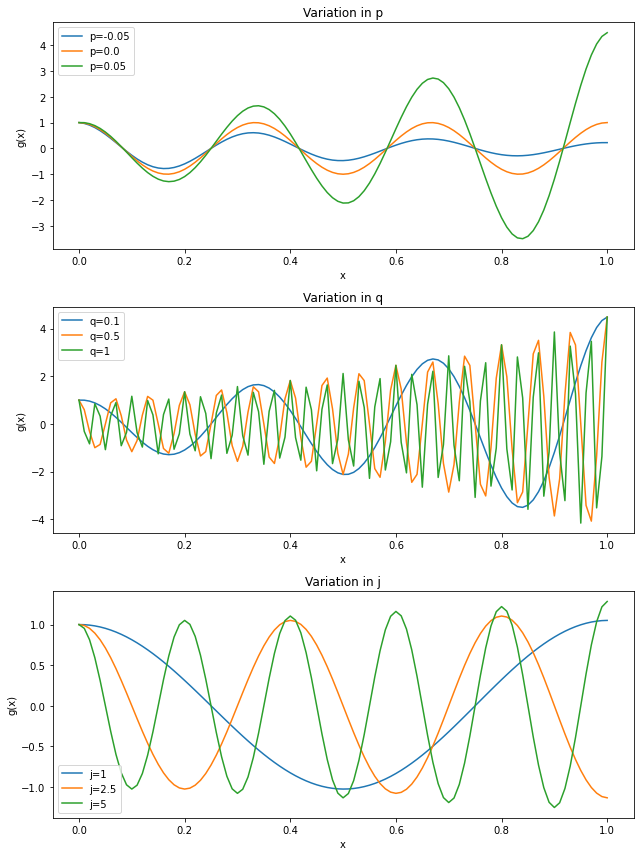

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(9, 12))

# plot variations in p
for p in p_values:
    axs[0].plot(x_nodes, kernel_function(x_nodes, j, p, q), label=f'p={p}')
axs[0].set_title("Variation in p")
axs[0].set_xlabel("x")
axs[0].set_ylabel("g(x)")
axs[0].legend()

# plot variations in q
for q in q_values:
    axs[1].plot(x_nodes, kernel_function(x_nodes, j, p, q), label=f'q={q}')
axs[1].set_title("Variation in q")
axs[1].set_xlabel("x")
axs[1].set_ylabel("g(x)")
axs[1].legend()

# plot variations in j
for j in j_values:
    axs[2].plot(x_nodes, kernel_function(x_nodes, j, p, q), label=f'j={j}')
axs[2].set_title("Variation in j")
axs[2].set_xlabel("x")
axs[2].set_ylabel("g(x)")
axs[2].legend()

plt.tight_layout()
plt.show()

#### Question 1b. Design a model that consists of a Gaussian and a boxcar 

In [6]:
# need to define x_centers 
x_centers  = 0.5*(x_nodes[:-1] + x_nodes[1:])

delta_x = np.diff(x_nodes)
x_centers2 = delta_x / 2 + x_nodes[:-1]

In [7]:
def get_model(
    x_centers,
    x_boxcar_min=0.2, x_boxcar_max=0.4, amplitude_boxcar=1,
    std_gaussian=0.05, amplitude_gaussian=-1, center_gaussian = 0.6
): 
    """
    Function to get a model with a boxcar and a gaussian
    """
    model = np.zeros(n_cells)
    
    # define a boxcar
    inds_boxcar = (x_centers >= x_boxcar_min) & (x_centers <= x_boxcar_max)
    model[inds_boxcar] = amplitude_boxcar
    
    # define a gaussian
    gaussian = amplitude_gaussian * np.exp(-(x_centers-center_gaussian)**2 / (2*std_gaussian**2))
    model = model + gaussian

    return model


Text(0.5, 1.0, 'Model of Gaussian + Boxcar Model')

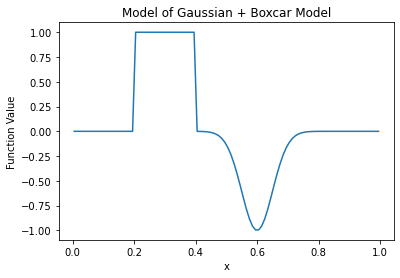

In [8]:
model = get_model(x_centers)
plt.plot(x_centers, model)
plt.xlabel('x')
plt.ylabel('Function Value')
plt.title('Model of Gaussian + Boxcar Model')

#### Question 1c - build model G

In [9]:
def get_G_nodes(x, n_kernels, j0, jN, p, q):
    j_values = np.linspace(j0, jN, n_kernels)
    n_nodes = len(x_nodes)
    G_nodes = np.zeros((n_nodes, n_kernels))

    for j, jk in enumerate(j_values): # j is the index; jk is the value
        G_nodes[:,j] = kernel_function(x=x_nodes, j=jk, p=p, q=q) # rows then columns
        
    return G_nodes

In [10]:
#forward simulation on matrix G
def get_G(x_nodes, n_kernels, j0, jN, p, q): 
    G_nodes = get_G_nodes(x_nodes, n_kernels, j0, jN, p, q)

    # Averaging matrix 
    av_entries = np.vstack(
        [0.5*np.ones(n_nodes), 0.5*np.ones(n_nodes)]
    )
    Av = sp.spdiags(av_entries, [0, 1] , m=n_cells, n=n_nodes) 

    delta_x = np.diff(x_nodes)
    diag_delta_x = sp.spdiags(delta_x, [0], m=n_cells, n=n_cells)


    temp = (Av @ G_nodes).T
    
    G = temp @ diag_delta_x

    return G

In [11]:
# Av: (100, 101)
# G nodes: (101, 20)

In [12]:
# Defining my paramters for matrix G
n_kernels = 20
n_cells = 100 #not required redefine, since it's defined above
n_nodes = n_cells + 1 #not required redefine, since it's defined above
x_nodes = np.linspace(0, 1, n_nodes) #not required redefine, since it's defined above
j0 = 1
jN = 30
p = -0.05
q = 0.1
G = get_G(x_nodes, n_kernels, j0, jN, p, q)
data = G @ model

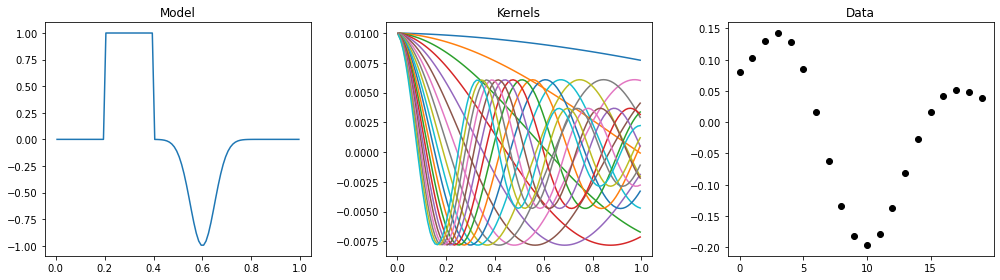

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

#model matrix dimension: 4 columns x 25 lines
ax[0].plot(x_centers, model, label=("true model"))
ax[0].set_title("Model")
ax[0].set_ylabel('')

#kernel matrix dimension: 30 x 100
ax[1].plot(x_centers, G.T)
ax[1].set_title("Kernels")
ax[1].set_ylabel(' ')

#data matrix dimention: 5 columns x 4 lines = there is one data associated with each kernel
ax[2].plot(data, "o", color="k", label=("true model"))
ax[2].set_title("Data")
ax[2].set_ylabel('')

plt.tight_layout()

#### Question 1d - sensitivity in amplitude of boxcar

In [14]:
def change_model_parameters_boxcar(model, data, x_centers, G, 
                                 amplitude_boxcar_orig= 1,
                                 new_amplitude_boxcar= 0.5):                        
    model_1 = get_model(
        x_centers,
        x_boxcar_min=0.2, x_boxcar_max=0.4, amplitude_boxcar = new_amplitude_boxcar,
        std_gaussian=0.05, amplitude_gaussian = -1, center_gaussian = 0.6
    )
   
     
    #data = G @ model_1
    new_data1 = G @ model_1
    sensitivity_change = amplitude_boxcar_orig - new_amplitude_boxcar
    
    sensitivity = []
                                 
    for i in range(len(data)):
        sensitivity_val = (data[i] - new_data1[i])/sensitivity_change
        sensitivity.append(sensitivity_val)
    
    return x_centers, model, model_1, sensitivity, data, amplitude_boxcar_orig, new_data1, new_amplitude_boxcar

    change_model_parameters_boxcar = new_data1

In [15]:
#quantify the sensitivity using the euqation provided 
x_centers, model, model_1, sensitivity, data, amplitude_boxcar_orig, new_data1, new_amplitude_boxcar = change_model_parameters_boxcar(model, data, x_centers, G)

SEN_boxcar = np.linalg.norm(new_data1 - data)/ np.linalg.norm(model_1 - model)

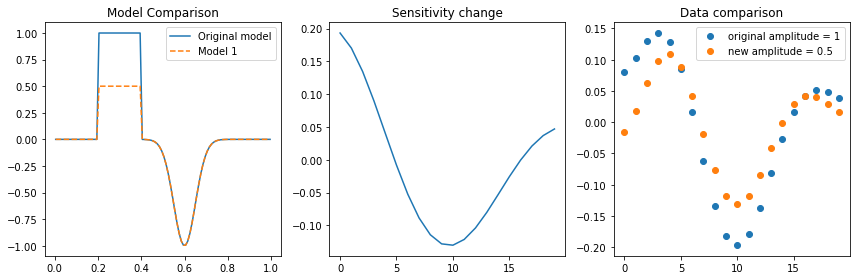

Sensitivity (boxcar): 0.0977


In [16]:
x_centers, model, model_1, sensitivity, data, amplitude_boxcar_orig, new_data1, new_amplitude_boxcar = change_model_parameters_boxcar(model,
 data, x_centers, G, amplitude_boxcar_orig = 1, new_amplitude_boxcar=0.5)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(x_centers, model, label="Original model")
ax[0].plot(x_centers, model_1, '--', label="Model 1")
ax[0].legend()
ax[0].set_title("Model Comparison")

ax[1].plot(sensitivity)
ax[1].set_title("Sensitivity change")

ax[2].plot(data, 'o', label = f'original amplitude = {amplitude_boxcar_orig}')
ax[2].plot(new_data1, 'o', label = f'new amplitude = {new_amplitude_boxcar}')
ax[2].set_title("Sensitivity change")
ax[2].legend()
ax[2].set_title("Data comparison")

plt.tight_layout()
plt.show()

print(f"Sensitivity (boxcar): {SEN_boxcar:.4f}")


#### Question 1d - sensitivity in amplitude of gaussian

In [17]:
def change_model_parameters_gaus(model, data, x_centers, G, 
                                 amplitude_gaussian_orig= -1, 
                                 new_amplitude_gaussian=-0.5):                        
    model_2 = get_model(
        x_centers,
        x_boxcar_min=0.2, x_boxcar_max=0.4, amplitude_boxcar = 1,
        std_gaussian=0.05, amplitude_gaussian = new_amplitude_gaussian, center_gaussian = 0.6
    )
   
     
    #data = G @ model_2
    new_data2 = G @ model_2
    sensitivity_change = amplitude_gaussian_orig - new_amplitude_gaussian
    
    sensitivity = []
                                 
    for i in range(len(data)):
        sensitivity_val = (data[i] - new_data2[i])/sensitivity_change
        sensitivity.append(sensitivity_val)
    
    return x_centers, model, model_2, sensitivity, data, amplitude_gaussian_orig, new_data2, new_amplitude_gaussian

In [18]:
x_centers, model, model_2, sensitivity, data, amplitude_gaussian_orig, new_data2, new_amplitude_gaussian = change_model_parameters_gaus(model, data, x_centers, G)

SEN_gaussian = np.linalg.norm(new_data2 - data)/ np.linalg.norm(model_2 - model)

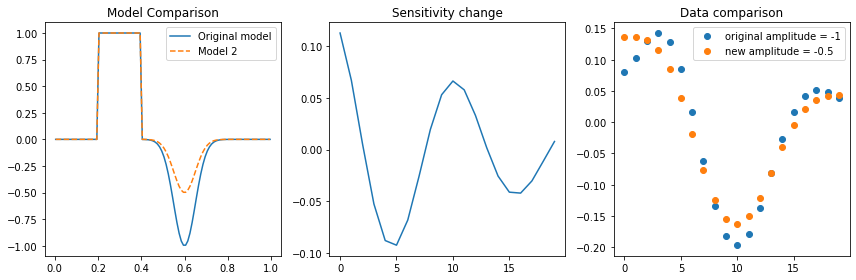

Sensitivity (gaussian): 0.0817


In [19]:
x_centers, model, model_2, sensitivity, data, amplitude_gaussian_orig, new_data2, new_amplitude_gaussian = change_model_parameters_gaus(model,
  data, x_centers, G,amplitude_gaussian_orig = -1, new_amplitude_gaussian=-0.5)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(x_centers, model, label="Original model")
ax[0].plot(x_centers, model_2, '--', label="Model 2")
ax[0].legend()
ax[0].set_title("Model Comparison")

ax[1].plot(sensitivity)
ax[1].set_title("Sensitivity change")

ax[2].plot(data, 'o', label = f'original amplitude = {amplitude_gaussian_orig}')
ax[2].plot(new_data2, 'o', label = f'new amplitude = {new_amplitude_gaussian}')
ax[2].set_title("Sensitivity change")
ax[2].legend()
ax[2].set_title("Data comparison")

plt.tight_layout()
plt.show()
print(f"Sensitivity (gaussian): {SEN_gaussian:.4f}")

#### Question 1e - using q = 0.05

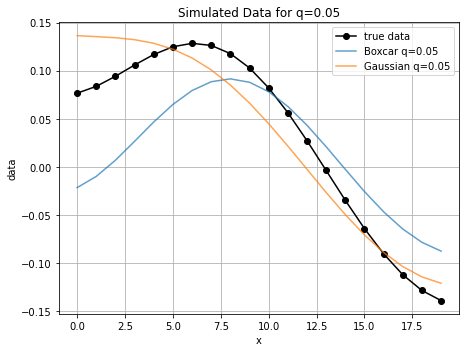

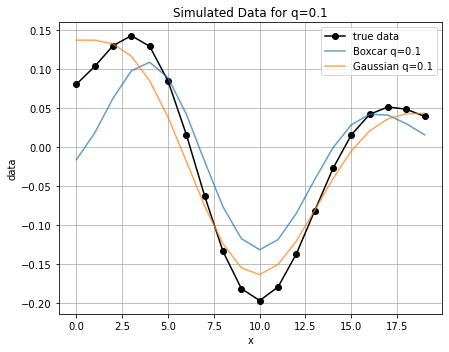

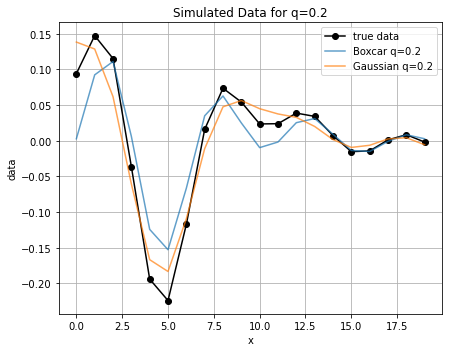

In [20]:
# Defining my paramters for matrix G
n_kernels = 20
p = -0.05
q = 0.1
q_values = [0.05, 0.1, 0.2]
j0 = 1
jN = 30
j_values = np.linspace(j0, jN, n_kernels)

new_amplitude_gaussian = -1
new_amplitude_boxcar = 2

# to store sensitivity results
sensitivity_boxcar = []
sensitivity_gaussian = []

# loop different q values
for i, q in enumerate(q_values):
    # greate G matrix for each q
    G = get_G(x_nodes, n_kernels, j0, jN, p, q)
    
    # compute original data
    data = G @ model
        
    # create models for sensitivity
    model1 = change_model_parameters_boxcar(model, data, x_centers, G, amplitude_boxcar_orig = 1, new_amplitude_boxcar=-1)
    model2 = change_model_parameters_gaus(model, data, x_centers, G,amplitude_gaussian_orig = -1, new_amplitude_gaussian=-2)
    
    # generate new G for sensitivity
    
    G_boxcar_SEN = get_G(x_nodes, n_kernels, j0, jN, p, q)
    G_gaussian_SEN = get_G(x_nodes, n_kernels, j0, jN, p, q)
    
    # compute new data
    
    new_amplitude_boxcar = G_boxcar_SEN @ model_1
    new_amplitude_gaussian = G_gaussian_SEN @ model_2

    # compute sensitivity using the equation
    SEN_boxcar = np.linalg.norm(new_amplitude_boxcar - data) / np.linalg.norm(model_1 - model)
    SEN_gaussian = np.linalg.norm(new_amplitude_gaussian - data) / np.linalg.norm(model_2 - model)

    # store results
    sensitivity_boxcar.append(new_amplitude_boxcar)
    sensitivity_gaussian.append(new_amplitude_gaussian)

    plt.figure(figsize=(18, 5))
    #for i, q in enumerate(q_values):    when using this, charts are plot in the worng way
    # Plot data for each q
    plt.subplot(1, len(q_values), i + 1)
    plt.plot(data, "o-", color="k", label="true data")
    plt.plot(new_amplitude_boxcar, label=f"Boxcar q={q}", alpha=0.7)
    plt.plot(new_amplitude_gaussian, label=f"Gaussian q={q}", alpha=0.7)
    plt.xlabel("x")
    plt.ylabel("data")
    plt.title(f"Simulated Data for q={q}")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

#### Question 1e - changing p, when q = 0.1

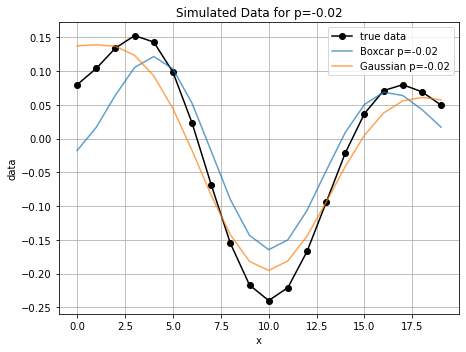

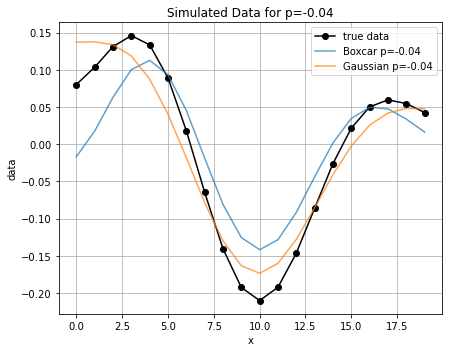

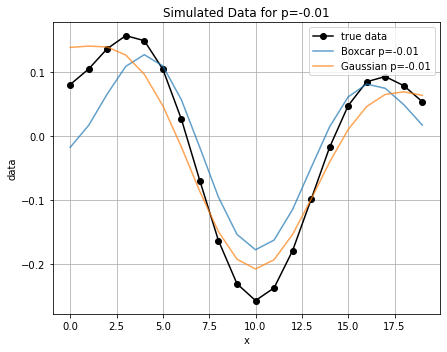

In [21]:
# Defining my paramters for matrix G
n_kernels = 20
p = -0.05
q = 0.1
p_values = [-0.02, -0.04, -0.01]
j0 = 1
jN = 30
j_values = np.linspace(j0, jN, n_kernels)

new_amplitude_gaussian = -1
new_amplitude_boxcar = 2

# to store sensitivity results
sensitivity_boxcar = []
sensitivity_gaussian = []

# loop different q values
for i, p in enumerate(p_values):
    # greate G matrix for each q
    G = get_G(x_nodes, n_kernels, j0, jN, p, q)
    
    # compute original data
    data = G @ model
        
    # create models for sensitivity
    model1 = change_model_parameters_boxcar(model, data, x_centers, G, amplitude_boxcar_orig = 1, new_amplitude_boxcar=-1)
    model2 = change_model_parameters_gaus(model, data, x_centers, G,amplitude_gaussian_orig = -1, new_amplitude_gaussian=-2)

    # generate new G for sensitivity
    
    G_boxcar_SEN = get_G(x_nodes, n_kernels, j0, jN, p, q)
    G_gaussian_SEN = get_G(x_nodes, n_kernels, j0, jN, p, q)

    new_amplitude_boxcar = G_boxcar_SEN @ model_1
    new_amplitude_gaussian = G_gaussian_SEN @ model_2

    # compute sensitivity using the equation
    SEN_boxcar = np.linalg.norm(new_amplitude_boxcar - data) / np.linalg.norm(model_1 - model)
    SEN_gaussian = np.linalg.norm(new_amplitude_gaussian - data) / np.linalg.norm(model_2 - model)

    # store results
    sensitivity_boxcar.append(new_amplitude_boxcar)
    sensitivity_gaussian.append(new_amplitude_gaussian)

    plt.figure(figsize=(18, 5))
    #for i, p in enumerate(p_values):    when using this, charts are plot in the worng way
    # Plot data for each p
    plt.subplot(1, len(p_values), i + 1)
    plt.plot(data, "-o", color="k", label="true data")
    plt.plot(new_amplitude_boxcar, label=f"Boxcar p={p}", alpha=0.7)
    plt.plot(new_amplitude_gaussian, label=f"Gaussian p={p}", alpha=0.7)
    plt.xlabel("x")
    plt.ylabel("data")
    plt.title(f"Simulated Data for p={p}")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

### Question 2a

In [22]:
std = 0.01
beta = 0.1
alpha_s = 1.0
alpha_x = 1.0
#x_nodes_test = np.array([0, 1, 5])
x_nodes_test = np.array([0, 1, 2, 3, 4])

n_kernel_2 = 2
#G_test = get_G(x_nodes_test, n_kernel_2, j0, jN, p, q)

G_test = np.array([
    [0.5, 0.5, 0, 0],
    [0, 0.5, 0.5, 0]
 ])

# Construct Wd data misfit term (data weighting matrix)
n_kernel_test = G_test.shape[0]
diagonal = 1/std * np.ones(n_kernel_test)
Wd = sp.diags(diagonal, 0, shape=(n_kernel_test, n_kernel_test))

# regularization -- Ws, Wx
delta_x_test = np.diff(x_nodes_test) 
n_cells_test = 4
Ws = sp.diags(np.sqrt(delta_x_test), 0, shape=(n_cells_test, n_cells_test))

inverse_delta__test = 1 / np.sqrt(delta_x_test)
diagonals = [-inverse_delta__test, inverse_delta__test]
Wx = sp.diags(diagonals, [0, 1], shape=(n_cells_test-1, n_cells_test))


Wx_add_btm_row = sp.vstack([
    Wx,  # (n-1) x n matrix
    sp.csr_matrix((1, n_cells_test))  # Add a zero row to make it n x n
])

# sum Ws and Wx 
Wm = alpha_s * Ws + alpha_x * Wx_add_btm_row

print("Wd:", Wd.shape)
print("Ws:", Ws.shape)
print("Wx:", Wx.shape)
print("Wm:", Wm.shape)

Wd: (2, 2)
Ws: (4, 4)
Wx: (3, 4)
Wm: (4, 4)


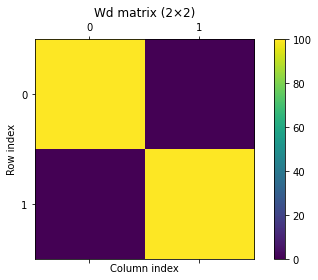

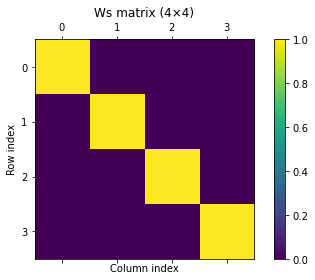

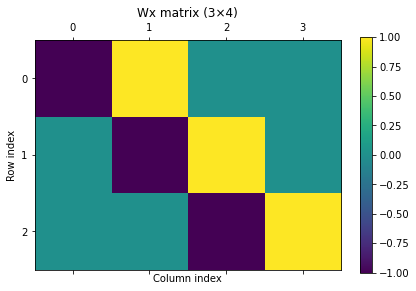


Wd: (2, 2)
Ws: (4, 4)
Wx: (3, 4)
Wm: (4, 4)


In [23]:
# Visualize Wd
plt.figure(figsize=(6, 4))
plt.matshow(Wd.toarray(), fignum=False)
plt.colorbar()
plt.title(f"Wd matrix ({Wd.shape[0]}×{Wd.shape[1]})")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.tight_layout()
plt.show()
print()

# Visualize Ws
plt.figure(figsize=(6, 4))
plt.matshow(Ws.toarray(), fignum=False)
plt.colorbar()
plt.title(f"Ws matrix ({Ws.shape[0]}×{Ws.shape[1]})")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.tight_layout()
plt.show()
print()


# Visualize Wx
plt.figure(figsize=(6, 4))
plt.matshow(Wx.toarray(), fignum=False)
plt.colorbar()
plt.title(f"Wx matrix ({Wx.shape[0]}×{Wx.shape[1]})")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.tight_layout()
plt.show()
print()

print("Wd:", Wd.shape)
print("Ws:", Ws.shape)
print("Wx:", Wx.shape)
print("Wm:", Wm.shape)

### Question 2 b

In [24]:
def design_model(
    x_centers,
    x_boxcar_min=0.2, x_boxcar_max=0.4, amplitude_boxcar=1,
    std_gaussian=0.05, amplitude_gaussian=-1, center_gaussian=0.6
):
    """
    Function to get a model with a boxcar and a gaussian
    """
    n_cells = len(x_centers)
    model = np.zeros(n_cells)
    
    # define a boxcar
    inds_boxcar = (x_centers >= x_boxcar_min) & (x_centers <= x_boxcar_max)
    model[inds_boxcar] = amplitude_boxcar
    
    # define a gaussian
    gaussian = amplitude_gaussian * np.exp(-(x_centers-center_gaussian)**2 / (2*std_gaussian**2))
    model = model + gaussian
    
    return model

In [25]:
def kernel_function(x, j, p, q):
    return (
        np.exp(j * p * x) *
        np.cos(2 * np.pi * j * q * x)
    )

def create_G(x_nodes, n_kernels, j0, jN, p, q):
    """
    Create the forward simulation matrix G
    """
    j_values = np.linspace(j0, jN, n_kernels)
    n_cells = len(x_nodes) - 1
    
    # Create G_nodes first (kernels evaluated at node locations)
    G_nodes = np.zeros((len(x_nodes), n_kernels))
    for j, jk in enumerate(j_values):
        G_nodes[:,j] = kernel_function(x=x_nodes, j=jk, p=p, q=q)
    
    # Create averaging matrix
    av_entries = np.vstack([0.5*np.ones(len(x_nodes)), 0.5*np.ones(len(x_nodes))])
    Av = sp.spdiags(av_entries, [0, 1], m=n_cells, n=len(x_nodes))
    
    # Create delta_x matrix
    delta_x = np.diff(x_nodes)
    diag_delta_x = sp.spdiags(delta_x, [0], m=n_cells, n=n_cells)
    
    # Compute G
    temp = (Av @ G_nodes).T
    G = temp @ diag_delta_x
    
    return G

In [26]:
def estimate_m(x_nodes, dobs, G, std, mref, alpha_s, alpha_x, beta=1.0): 

    # Check dimensions
    n_data = len(dobs)
    n_cells = len(x_nodes) - 1
    
    print(f"Data points: {n_data}")
    print(f"Model parameters: {n_cells}")
    print(f"G shape: {G.shape}")
    
    # Construct data weights matrix Wd
    Wd = sp.diags(1/std * np.ones(n_data), 0)
    
    # Construct smallness weights matrix Ws
    Ws = sp.eye(n_cells)
    
    # Construct smoothness weights matrix Wx
    delta_x = np.diff(x_nodes)
    dx_inv = 1.0 / delta_x
    
    # First derivative operator (n_cells-1 × n_cells)
    D = sp.diags([-dx_inv, dx_inv], [0, 1], shape=(n_cells-1, n_cells))
    
    # Create scaling matrix with sqrt(delta_x) - this is key to fix the dimensional issue
    sqrt_dx = np.sqrt(delta_x)
    scaling = sp.diags(sqrt_dx, 0, shape=(n_cells-1, n_cells-1))
    
    # Create Wx as scaling * D
    Wx = scaling @ D
    
    # Print matrix shapes for debugging
    print("Wd shape:", Wd.shape)
    print("Ws shape:", Ws.shape)
    print("Wx shape:", Wx.shape)
    
    # Construct system matrix H and right-hand side rhs as in professor's notes
    H = (G.T @ Wd.T @ Wd @ G + 
         beta * (alpha_s * Ws.T @ Ws + alpha_x * Wx.T @ Wx))
    
    rhs = G.T @ Wd.T @ Wd @ dobs
    if not np.all(mref == 0):
        rhs = rhs + beta * (alpha_s * Ws.T @ Ws @ mref)
    
    # Solve system
    m_recovered = np.linalg.solve(H, rhs)
    
    # Compute predicted data
    dpred = G @ m_recovered
    
    # Compute data misfit
    residual = dpred - dobs
    Wd_r = Wd @ residual
    phid = Wd_r.T @ Wd_r
    
    # Compute model misfit
    m_diff = m_recovered - mref
    phim_s = alpha_s * (Ws @ m_diff).T @ (Ws @ m_diff)
    phim_x = alpha_x * (Wx @ m_recovered).T @ (Wx @ m_recovered)
    phim = phim_s + phim_x
    
    return m_recovered, dpred, phid, phim

In [72]:
def plot_recovered_model(x_centers, model, m_recovered, G, dobs, dpred, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].plot(x_centers, model, label="true model")
    #ax[0].plot(x_centers, m_recovered, label="recovered model") 
    ax[0].set_title("Model")
    ax[0].legend()
    
    ax[1].plot(x_centers, G.T)
    ax[1].set_title("Kernels")
    
    ax[2].plot(dobs, "o-", color="k", label="dobs")
    #ax[2].plot(dpred, "-", color="r", label="dpred")
    ax[2].set_title("Data")
    ax[2].legend()
    
    plt.tight_layout()
    return ax

Data points: 20
Model parameters: 100
G shape: (20, 100)
Wd shape: (20, 20)
Ws shape: (100, 100)
Wx shape: (99, 100)


array([<AxesSubplot:title={'center':'Model'}>,
       <AxesSubplot:title={'center':'Kernels'}>,
       <AxesSubplot:title={'center':'Data'}>], dtype=object)

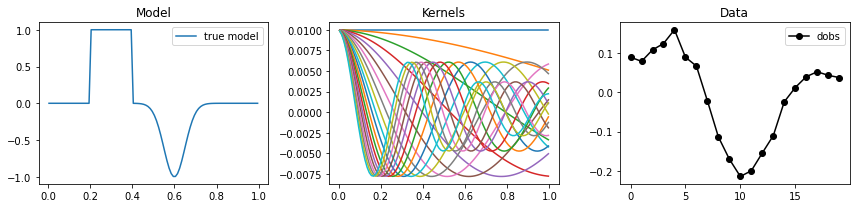

In [73]:
# Set up the model and forward simulation
n_cells = 100
n_nodes = n_cells + 1
x_nodes = np.linspace(0, 1, n_nodes)
x_centers = 0.5*(x_nodes[:-1] + x_nodes[1:])
n_kernels = 20
p = -0.05
q = 0.1
j0 = 0
jN = 30

# Create model
model = design_model(x_centers)

# Forward simulation
G = create_G(x_nodes, n_kernels, j0, jN, p, q)
noise_level = 0.01
dobs = G @ model + noise_level * np.random.randn(n_kernels)

# Inversion parameters
beta = 2e0
std = noise_level
alpha_s = 1
alpha_x = 0
mref = np.zeros(G.shape[1])

# Run inversion
m_recovered, dpred, phid, phim = estimate_m(x_nodes, dobs, G, std, mref, alpha_s, alpha_x, beta)

# Plot results
plot_recovered_model(x_centers, model, m_recovered, G, dobs, dpred)

### Question 2c as = 1 and ax = 0

In [29]:
def estimate_m_with_beta(x_nodes, dobs, G, std, mref, alpha_s, alpha_x, beta): 

    # Check dimensions
    n_data = len(dobs)
    n_cells = len(x_nodes) - 1
      
    # Construct data weights matrix Wd
    Wd = sp.diags(1/std * np.ones(n_data), 0)
    
    # Construct smallness weights matrix Ws
    Ws = sp.eye(n_cells)
    
    # Construct smoothness weights matrix Wx
    delta_x = np.diff(x_nodes)
    dx_inv = 1.0 / delta_x
    
    # First derivative operator (n_cells-1 × n_cells)
    D = sp.diags([-dx_inv, dx_inv], [0, 1], shape=(n_cells-1, n_cells))
    
    # Create scaling matrix with sqrt(delta_x) - this is key to fix the dimensional issue
    sqrt_dx = np.sqrt(delta_x)
    scaling = sp.diags(sqrt_dx, 0, shape=(n_cells-1, n_cells-1))
    
    # Create Wx as scaling * D
    Wx = scaling @ D
    
    # Construct system matrix H and right-hand side rhs as in professor's notes
    H = (G.T @ Wd.T @ Wd @ G + 
         beta * (alpha_s * Ws.T @ Ws + alpha_x * Wx.T @ Wx))
    
    rhs = G.T @ Wd.T @ Wd @ dobs
    if not np.all(mref == 0):
        rhs = rhs + beta * (alpha_s * Ws.T @ Ws @ mref)
    
    # Solve system
    m_recovered_beta = np.linalg.solve(H, rhs)
    
    # Compute predicted data
    dpred = G @ m_recovered_beta
    
    # Compute data misfit
    residual = dpred - dobs
    Wd_r = Wd @ residual
    phid_beta = Wd_r.T @ Wd_r
    
    # Compute model misfit
    m_diff = m_recovered_beta - mref
    phim_s = alpha_s * (Ws @ m_diff).T @ (Ws @ m_diff)
    phim_x = alpha_x * (Wx @ m_recovered_beta).T @ (Wx @ m_recovered_beta)
    phim = phim_s + phim_x
    
    return m_recovered_beta, dpred, phid_beta, phim

In [30]:
def plot_recovered_model_beta(x_centers, model, m_recovered, G, dobs, dpred, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].plot(x_centers, model, label="true model")
    ax[0].plot(x_centers, m_recovered, label="recovered model") 
    ax[0].set_title("Model")
    ax[0].legend()
    
    ax[1].plot(x_centers, G.T)
    ax[1].set_title("Kernels")
    
    ax[2].plot(dobs, "o-", color="k", label="dobs")
    ax[2].plot(dpred, "-", color="r", label="dpred")
    ax[2].set_title("Data")
    ax[2].legend()
    
    plt.tight_layout()
    return ax

array([<AxesSubplot:title={'center':'Model'}>,
       <AxesSubplot:title={'center':'Kernels'}>,
       <AxesSubplot:title={'center':'Data'}>], dtype=object)

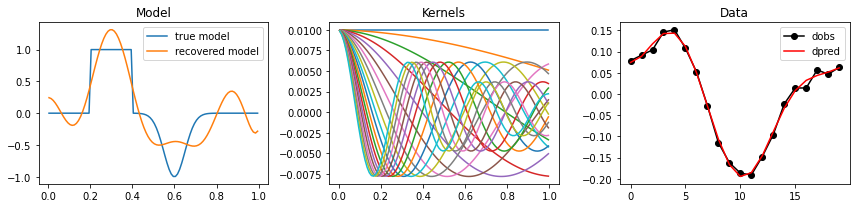

In [31]:
# Set up the model and forward simulation
n_cells = 100
n_nodes = n_cells + 1
x_nodes = np.linspace(0, 1, n_nodes)
x_centers = 0.5*(x_nodes[:-1] + x_nodes[1:])
n_kernels = 20
p = -0.05
q = 0.1
j0 = 0
jN = 30

# Create model
model = design_model(x_centers)

# Forward simulation
G = create_G(x_nodes, n_kernels, j0, jN, p, q)
noise_level = 1e-2
dobs = G @ model + noise_level * np.random.randn(n_kernels)

# Inversion parameters
beta = 5e-2
std = noise_level
alpha_s = 1
alpha_x = 0
mref = np.zeros(G.shape[1])

# Run inversion
m_recovered_beta, dpred, phid_beta, phim = estimate_m_with_beta(x_nodes, dobs, G, std, mref, alpha_s, alpha_x, beta)

# Plot results
plot_recovered_model_beta(x_centers, model, m_recovered_beta, G, dobs, dpred)

In [32]:
print(phid_beta)

12.170206454046594


### Question 2c as = 0 and ax = 1

In [33]:
def estimate_m_with_beta2(x_nodes, dobs, G, std, mref, alpha_s, alpha_x, beta):

    # Check dimensions
    n_data = len(dobs)
    n_cells = len(x_nodes) - 1
      
    # Construct data weights matrix Wd
    Wd = sp.diags(1/std * np.ones(n_data), 0)
    
    # Construct smallness weights matrix Ws
    Ws = sp.eye(n_cells)
    
    # Construct smoothness weights matrix Wx
    delta_x = np.diff(x_nodes)
    dx_inv = 1.0 / delta_x
    
    # First derivative operator (n_cells-1 × n_cells)
    D = sp.diags([-dx_inv, dx_inv], [0, 1], shape=(n_cells-1, n_cells))
    
    # Create scaling matrix with sqrt(delta_x) - this is key to fix the dimensional issue
    sqrt_dx = np.sqrt(delta_x)
    scaling = sp.diags(sqrt_dx, 0, shape=(n_cells-1, n_cells-1))
    
    # Create Wx as scaling * D
    Wx = scaling @ D
    
    # Construct system matrix H and right-hand side rhs as in professor's notes
    H = (G.T @ Wd.T @ Wd @ G + 
         beta * (alpha_s * Ws.T @ Ws + alpha_x * Wx.T @ Wx))
    
    rhs = G.T @ Wd.T @ Wd @ dobs
    if not np.all(mref == 0):
        rhs = rhs + beta * (alpha_s * Ws.T @ Ws @ mref)
    
    # Solve system
    m_recovered_beta2 = np.linalg.solve(H, rhs)
    
    # Compute predicted data
    dpred = G @ m_recovered_beta2
    
    # Compute data misfit
    residual = dpred - dobs
    Wd_r = Wd @ residual
    phid_beta = Wd_r.T @ Wd_r
    
    # Compute model misfit
    m_diff = m_recovered_beta2 - mref
    phim_s = alpha_s * (Ws @ m_diff).T @ (Ws @ m_diff)
    phim_x = alpha_x * (Wx @ m_recovered_beta2).T @ (Wx @ m_recovered_beta2)
    phim = phim_s + phim_x
    
    return m_recovered_beta2, dpred, phid_beta, phim

In [34]:
def plot_recovered_model_beta(x_centers, model, m_recovered2, G, dobs, dpred, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].plot(x_centers, model, label="true model")
    ax[0].plot(x_centers, m_recovered2, label="recovered model") 
    ax[0].set_title("Model")
    ax[0].legend()
    
    ax[1].plot(x_centers, G.T)
    ax[1].set_title("Kernels")
    
    ax[2].plot(dobs, "o-", color="k", label="dobs")
    ax[2].plot(dpred, "-", color="r", label="dpred")
    ax[2].set_title("Data")
    ax[2].legend()
    
    plt.tight_layout()
    return ax

array([<AxesSubplot:title={'center':'Model'}>,
       <AxesSubplot:title={'center':'Kernels'}>,
       <AxesSubplot:title={'center':'Data'}>], dtype=object)

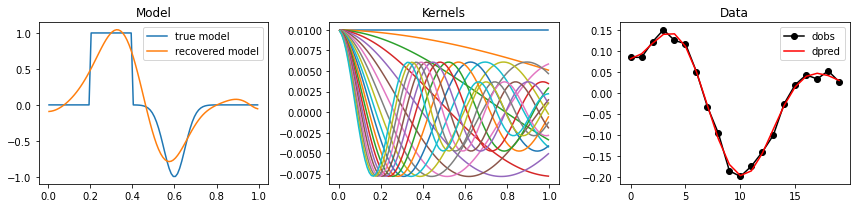

In [35]:
# Set up the model and forward simulation
n_cells = 100
n_nodes = n_cells + 1
x_nodes = np.linspace(0, 1, n_nodes)
x_centers = 0.5*(x_nodes[:-1] + x_nodes[1:])
n_kernels = 20
p = -0.05
q = 0.1
j0 = 0
jN = 30

# Create model
model = design_model(x_centers)

# Forward simulation
G = create_G(x_nodes, n_kernels, j0, jN, p, q)
noise_level = 1e-2
dobs = G @ model + noise_level * np.random.randn(n_kernels)

# Inversion parameters
beta = 1e-2
std = noise_level
alpha_s = 0
alpha_x = 1
mref = np.zeros(G.shape[1])

# Run inversion
m_recovered_beta2, dpred, phid_beta, phim = estimate_m_with_beta2(x_nodes, dobs, G, std, mref, alpha_s, alpha_x, beta)

# Plot results
plot_recovered_model_beta(x_centers, model, m_recovered_beta2, G, dobs, dpred)

In [36]:
print(phid_beta)

16.423957138263294


# Question 3

### Question 3a - Set αs = 1, αx = 0

In [37]:
def run_inversions(x_nodes, dobs, G, std, 
                   beta_min, beta_max, n_beta, 
                   alpha_s, alpha_x, mref
                  ):
    # create a vector for beta
    betas = np.logspace(beta_max, beta_min, n_beta) 
    
    M_recovered = np.zeros((n_cells, n_beta))
    D_pred = np.zeros((n_kernels, n_beta))
    phids = np.zeros(n_beta)
    phims = np.zeros(n_beta) 
    
    for i, beta in enumerate(betas): 
        mrec, dpred, phid, phim = estimate_m_with_beta2(x_nodes, dobs, G, std, mref, alpha_s, alpha_x, beta)
        M_recovered[:, i] = mrec
        D_pred[:, i] = dpred
        phids[i] = phid
        phims[i] = phim
    return betas, M_recovered, D_pred, phids, phims

In [38]:
def find_intersection(x, y, y_const):
    for i in range(len(y) - 1):
        if (y[i] - y_const) * (y[i + 1] - y_const) < 0:
            
            # Linear interpolation to find the x-value of the intersection
            x_intersect = x[i] + (x[i + 1] - x[i]) * (y_const - y[i]) / (y[i + 1] - y[i])
            return x_intersect
    return None

In [39]:
def plot_tikhonov_curves(betas, phids, phims, iteration=0, n_kernels=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].semilogx(betas, phids) 
    ax[0].semilogx(betas[iteration], phids[iteration], "ro")
    
    if n_kernels is not None: 
        ax[0].semilogx(betas, n_kernels*np.ones_like(betas), "--k")
        beta_intersect = find_intersection(betas, phids, n_kernels)
        if beta_intersect:
            ax[0].semilogx(beta_intersect, n_kernels, "k*", markersize = "9")

    ax[0].set_xlim([betas.max(), betas.min()])
    ax[0].set_xlabel("$\\beta$")
    ax[0].set_ylabel("$\\phi_d$")
    
    ax[1].semilogx(betas, phims) 
    ax[1].semilogx(betas[iteration], phims[iteration], "ro")
    ax[1].set_xlim([betas.max(), betas.min()])
    ax[1].set_xlabel("$\\beta$")
    ax[1].set_ylabel("$\\phi_m$")
    
    ax[2].plot(phims, phids)
    ax[2].plot(phims[iteration], phids[iteration], "ro")
    if n_kernels is not None:
        ax[2].semilogx(phims, n_kernels*np.ones_like(phims), "--k")
        phim_intersect = find_intersection(phims, phids, n_kernels)
        if phim_intersect:
            ax[2].plot(phim_intersect, n_kernels, "k*", markersize = "9")

    ax[2].set_xlabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    
    # ax[0].set_ylim([-1, 200])
    plt.tight_layout()
    return ax 

In [40]:
def plot_iteration(
    x_nodes, true_model, dobs, G, std,  
    beta_min, beta_max, n_beta,
    alpha_s, alpha_x, mref, 
    iteration=0,
    ax=None): # alpha_s, alpha_x

    betas, M_recovered, D_pred, phids, phims = run_inversions(
        x_nodes, dobs, G, std, 
        beta_min, beta_max, n_beta,
        alpha_s, alpha_x, mref=mref
    ) 
    
    # create a plot with 2 rows
    if ax is None: 
        fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    
    # top plots - model, data 
    m_recovered = M_recovered[:, iteration]
    dpred = D_pred[:, iteration]
    x_centers = x_nodes[0:-1] + np.diff(x_nodes)/2
    plot_recovered_model(
        x_centers, true_model, m_recovered, G, dobs, dpred,
        ax=ax[0, :]
    )
    
    # bottom plots - tikhonov curves 
    n_kernels = G.shape[0]
    plot_tikhonov_curves(
        betas, phids, phims, n_kernels=n_kernels, iteration=iteration,
        ax=ax[1, :]
    )

    return ax

array([[<AxesSubplot:title={'center':'Model'}>,
        <AxesSubplot:title={'center':'Kernels'}>,
        <AxesSubplot:title={'center':'Data'}>],
       [<AxesSubplot:xlabel='$\\beta$', ylabel='$\\phi_d$'>,
        <AxesSubplot:xlabel='$\\beta$', ylabel='$\\phi_m$'>,
        <AxesSubplot:xlabel='$\\phi_m$', ylabel='$\\phi_d$'>]],
      dtype=object)

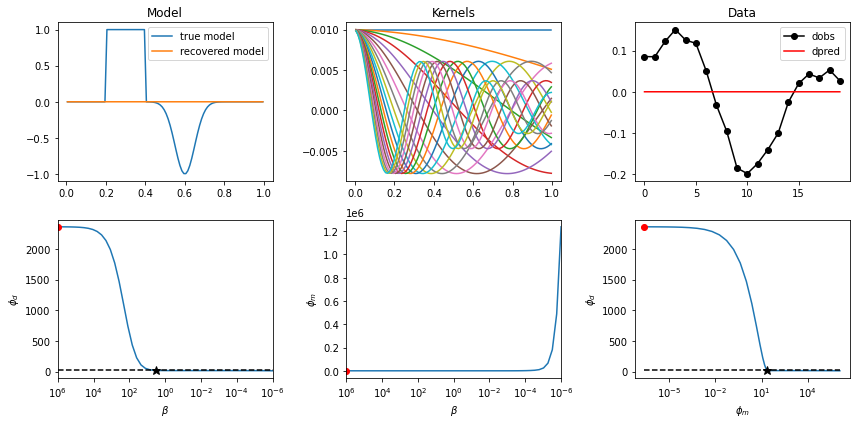

In [41]:
# set beta, alphas for question 3a 
beta_min = -6
beta_max = 6
n_beta = 50
alpha_s = 1
alpha_x = 0
mref = mref

# run inversion 
betas_3a, M_recovered_3a, D_pred_3a, phids_3a, phims_3a = run_inversions(x_nodes, dobs, G, std, beta_min, beta_max, n_beta,
                                                                        alpha_s, alpha_x, mref=mref
                                                                       )

plot_iteration(x_nodes, model, dobs, G, std, beta_min, beta_max, n_beta, alpha_s, alpha_x, mref, iteration=0)

In [42]:
def plot_iteration_interactive(std, iteration):
    plot_iteration(
        x_nodes, model, dobs, G, std,  
        beta_min, beta_max, n_beta,
        alpha_s, alpha_x, mref,
        iteration=iteration
    )


In [43]:
widgets.interact(
    plot_iteration_interactive,
    std=widgets.FloatText(value=noise_level),
    iteration=widgets.IntSlider(min=0, max=n_beta-1, value=0)
)

interactive(children=(FloatText(value=0.01, description='std'), IntSlider(value=0, description='iteration', ma…

<function __main__.plot_iteration_interactive(std, iteration)>

### Question 3b

In [44]:
def run_inversions(x_nodes, dobs, G, std, 
                   beta_min, beta_max, n_beta, 
                   alpha_s, alpha_x, mref
                  ):
    # create a vector for beta
    betas = np.logspace(beta_max, beta_min, n_beta) 
    
    M_recovered = np.zeros((n_cells, n_beta))
    D_pred = np.zeros((n_kernels, n_beta))
    phids = np.zeros(n_beta)
    phims = np.zeros(n_beta) 
    
    for i, beta in enumerate(betas): 
        mrec, dpred, phid, phim = estimate_m_with_beta(x_nodes, dobs, G, std, mref, alpha_s, alpha_x, beta)
        M_recovered[:, i] = mrec
        D_pred[:, i] = dpred
        phids[i] = phid
        phims[i] = phim
    return betas, M_recovered, D_pred, phids, phims

In [45]:
def find_intersection(x, y, y_const):
    for i in range(len(y) - 1):
        if (y[i] - y_const) * (y[i + 1] - y_const) < 0:
            
            # Linear interpolation to find the x-value of the intersection
            x_intersect = x[i] + (x[i + 1] - x[i]) * (y_const - y[i]) / (y[i + 1] - y[i])
            return x_intersect
    return None

In [46]:
def plot_tikhonov_curves(betas, phids, phims, iteration=0, n_kernels=None, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].semilogx(betas, phids) 
    ax[0].semilogx(betas[iteration], phids[iteration], "ro")
    
    if n_kernels is not None: 
        ax[0].semilogx(betas, n_kernels*np.ones_like(betas), "--k")
        beta_intersect = find_intersection(betas, phids, n_kernels)
        if beta_intersect:
            ax[0].semilogx(beta_intersect, n_kernels, "k*", markersize = "9")

    ax[0].set_xlim([betas.max(), betas.min()])
    ax[0].set_xlabel("$\\beta$")
    ax[0].set_ylabel("$\\phi_d$")
    
    ax[1].semilogx(betas, phims) 
    ax[1].semilogx(betas[iteration], phims[iteration], "ro")
    ax[1].set_xlim([betas.max(), betas.min()])
    ax[1].set_xlabel("$\\beta$")
    ax[1].set_ylabel("$\\phi_m$")
    
    ax[2].plot(phims, phids)
    ax[2].plot(phims[iteration], phids[iteration], "ro")
    if n_kernels is not None:
        ax[2].semilogx(phims, n_kernels*np.ones_like(phims), "--k")
        phim_intersect = find_intersection(phims, phids, n_kernels)
        if phim_intersect:
            ax[2].plot(phim_intersect, n_kernels, "k*", markersize = "9")

    ax[2].set_xlabel("$\\phi_m$")
    ax[2].set_ylabel("$\\phi_d$")
    
    # ax[0].set_ylim([-1, 200])
    plt.tight_layout()
    return ax 

In [47]:
def plot_iteration(
    x_nodes, true_model, dobs, G, std,  
    beta_min, beta_max, n_beta,
    alpha_s, alpha_x, mref, 
    iteration=0,
    ax=None): # alpha_s, alpha_x

    betas, M_recovered, D_pred, phids, phims = run_inversions(
        x_nodes, dobs, G, std, 
        beta_min, beta_max, n_beta,
        alpha_s, alpha_x, mref=mref
    ) 
    
    # create a plot with 2 rows
    if ax is None: 
        fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    
    # top plots - model, data 
    m_recovered = M_recovered[:, iteration]
    dpred = D_pred[:, iteration]
    x_centers = x_nodes[0:-1] + np.diff(x_nodes)/2
    plot_recovered_model(
        x_centers, true_model, m_recovered, G, dobs, dpred,
        ax=ax[0, :]
    )
    
    # bottom plots - tikhonov curves 
    n_kernels = G.shape[0]
    plot_tikhonov_curves(
        betas, phids, phims, n_kernels=n_kernels, iteration=iteration,
        ax=ax[1, :]
    )

    return ax

In [48]:
widgets.interact(
    plot_iteration_interactive,
    std=widgets.FloatText(value=noise_level),
    iteration=widgets.IntSlider(min=0, max=n_beta-1, value=0)
)


interactive(children=(FloatText(value=0.01, description='std'), IntSlider(value=0, description='iteration', ma…

<function __main__.plot_iteration_interactive(std, iteration)>

### Question 3b - trying debug

array([[<AxesSubplot:title={'center':'Model'}>,
        <AxesSubplot:title={'center':'Kernels'}>,
        <AxesSubplot:title={'center':'Data'}>],
       [<AxesSubplot:xlabel='$\\beta$', ylabel='$\\phi_d$'>,
        <AxesSubplot:xlabel='$\\beta$', ylabel='$\\phi_m$'>,
        <AxesSubplot:xlabel='$\\phi_m$', ylabel='$\\phi_d$'>]],
      dtype=object)

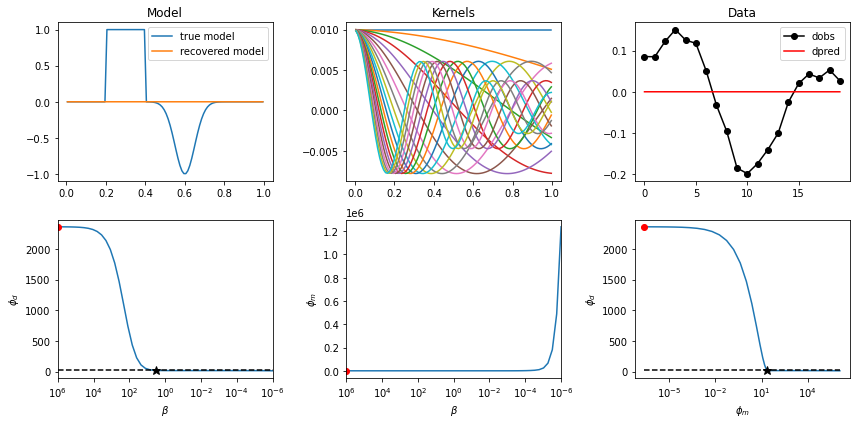

In [49]:
#parameters
beta_min = -6
beta_max = 6
n_beta = 50
alpha_s = 1
alpha_x = 0
mref = mref

# Inversion 
betas_3a, M_recovered_3a, D_pred_3a, phids_3a, phims_3a = run_inversions(x_nodes, dobs, G, std, beta_min, beta_max, n_beta,
                                                                        alpha_s, alpha_x, mref=mref
                                                                       )

plot_iteration(x_nodes, model, dobs, G, std, beta_min, beta_max, n_beta, alpha_s, alpha_x, mref, iteration=0)

In [51]:
widgets.interact(
    plot_iteration_interactive,
    std=widgets.FloatText(value=noise_level),
    iteration=widgets.IntSlider(min=0, max=n_beta-1, value=0)
)

interactive(children=(FloatText(value=0.01, description='std'), IntSlider(value=0, description='iteration', ma…

<function __main__.plot_iteration_interactive(std, iteration)>

### Question 3c - adding noise and changing oscillation

array([[<AxesSubplot:title={'center':'Model'}>,
        <AxesSubplot:title={'center':'Kernels'}>,
        <AxesSubplot:title={'center':'Data'}>],
       [<AxesSubplot:xlabel='$\\beta$', ylabel='$\\phi_d$'>,
        <AxesSubplot:xlabel='$\\beta$', ylabel='$\\phi_m$'>,
        <AxesSubplot:xlabel='$\\phi_m$', ylabel='$\\phi_d$'>]],
      dtype=object)

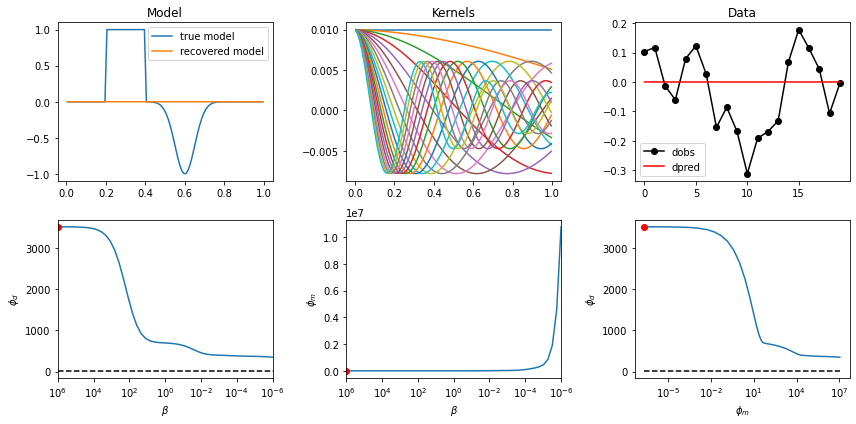

In [52]:
# parameters changed to increased noise level
std = 0.01         # Standard deviation for noise

# Beta and alpha values for inversion
beta_min = -6
beta_max = 6
n_beta = 50
alpha_s = 1
alpha_x = 0
noise_level = 0.09 # I RAN USING 0.03, 0.3

# Model reference (zero model)
mref = np.zeros(G.shape[1])  

# Forward simulation
G = create_G(x_nodes, n_kernels, j0, jN, p, q)
dobs = G @ model + noise_level * np.random.randn(n_kernels)  # Adding noise

# Inversion 
betas_3c1, M_recovered_3c1, D_pred_3c1, phids_3c1, phims_3c1 = run_inversions(
    x_nodes, dobs, G, std, 
    beta_min, beta_max, n_beta,
    alpha_s, alpha_x, mref
)

plot_iteration(
    x_nodes, model, dobs, G, std,
    beta_min, beta_max, n_beta,
    alpha_s, alpha_x, mref,
    iteration=0
)

In [53]:
widgets.interact(
    plot_iteration_interactive,
    std=widgets.FloatText(value=noise_level),
    iteration=widgets.IntSlider(min=0, max=n_beta-1, value=0)
)

interactive(children=(FloatText(value=0.09, description='std'), IntSlider(value=0, description='iteration', ma…

<function __main__.plot_iteration_interactive(std, iteration)>

## Question 4

##### Question 4a

In [54]:
n_cells = 100
n_nodes = n_cells + 1 # boundary conditions
x_nodes = np.linspace(0, 1, n_nodes)
x_centers = 0.5*(x_nodes[:-1] + x_nodes[1:])
n_kernels = 20
p = -0.05
q = 0.1
j0 = 0
jN = 30 
j_values = np.linspace(j0, jN, n_kernels)
noise_level = 0.02

G = create_G(x_nodes, n_kernels, j0, jN, p, q)
dobs = G @ model + noise_level * np.random.randn(n_kernels) # add noise 

In [55]:
# U, l, VT
U, l, VT = np.linalg.svd(G, full_matrices = False)
V = VT.T

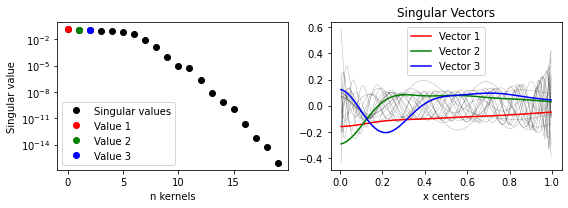

In [58]:
colors = ['r', 'g', 'b']  # Red, Green, Blue for the 3 vectors
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

x_singular_values = np.arange(n_kernels)
ax[0].semilogy(x_singular_values, l, "ko", label="Singular values")
ax[1].plot(x_centers, V, "k", linewidth=0.5, alpha=0.3)  # Background vectors in black (faint)

# Highlight key vectors with distinct colors
for i, color in enumerate(colors):
    ax[0].semilogy(x_singular_values[i], l[i], "o", color=color, label=f"Value {i+1}")
    ax[1].plot(x_centers, V[:, i], color=color, label=f"Vector {i+1}")

ax[0].set_xlabel("n kernels")
ax[0].set_ylabel("Singular value")
ax[0].legend()

ax[1].set_xlabel("x centers")
ax[1].set_title("Singular Vectors")
ax[1].legend()

plt.tight_layout()
plt.show()


#### Question 4b and 4c

In [59]:
def get_m_at_index(index):
    numerator = U[:, index].T @ dobs 
    m_at_index = (numerator / l[index]) * V[:, index]
    return m_at_index

In [60]:
def get_m_svd(n_vectors, x_centers):
    m_reconstructed = np.zeros_like(x_centers)
    for i in range(n_vectors):
        m_reconstructed += get_m_at_index(i)
    return m_reconstructed

In [61]:
def dmisfit(model, G, dobs, std=1):
    dpred = G @ model
    residual = dpred - dobs
    diagonal = 1/std * np.ones(G.shape[0])
    Wd = sp.diags(diagonal, 0, shape=(G.shape[0], G.shape[0]))
    Wdr = Wd @ residual
    return Wdr.T @ Wdr

In [62]:
def get_dpred(x_centers, n_kernels):

    # plot, model, singular values, dmisfit, # (singular vectors)
    mrec_all = np.zeros((len(x_centers), n_kernels)) # double buckets as a shape #column and row
    phid_all = np.zeros(n_kernels)
    
    # predicted data 
    for i in range(n_kernels):
        mrec_all[:, i] = get_m_svd(i, x_centers)
        phid_all[i] = dmisfit(mrec_all[:, i], G, dobs, std=noise_level)
    
    # compute dpred 
    dpred = G @ mrec_all

    return mrec_all, phid_all, dpred

In [63]:
n_vectors = 5
m_reconstructed = get_m_svd(n_vectors, x_centers)
mrec_all, phid_all, dpred = get_dpred(x_centers, n_kernels)

def plot_svd_results(n_vectors = 1):
    fig, ax = plt.subplots(1, 4, figsize = (12, 3))
    
    x_singular_values = np.arange(n_kernels)
    ax[0].semilogy(x_singular_values, l, "o")
    ax[0].semilogy(x_singular_values[n_vectors], l[n_vectors], "rs")
    ax[0].set_xlabel("n kernels")
    ax[0].set_ylabel("Singular value")
    
    ax[1].plot(x_singular_values, phid_all)
    ax[1].plot(x_singular_values[n_vectors], phid_all[n_vectors], "rs")
    ax[1].set_xlabel("p")
    ax[1].set_ylabel("$\\phi_d$")
    #ax[1].plot(n_kernels*np.ones_like(x_singular_values), n_kernels*np.ones_like(x_singular_values), "--k")
    
    ax[2].plot(x_centers, model, label="true model")
    ax[2].plot(x_centers, mrec_all[:, n_vectors], label="recovered model (SVD)")
    ax[2].legend()
    
    ax[3].plot(x_singular_values, dobs, label="dobs")
    ax[3].plot(x_singular_values, dpred[:, n_vectors], "k", label="dpred")
    ax[3].legend()
    
    plt.tight_layout()

In [64]:
widgets.interact(
    plot_svd_results, 
    n_vectors = widgets.IntSlider(min=1, max=n_kernels, value=1)
)

interactive(children=(IntSlider(value=1, description='n_vectors', max=20, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_svd_results(n_vectors=1)>

#### Question 4d

In [67]:
n_cells = 100 # 100 cells 
n_nodes = n_cells + 1 # boundary conditions
x_nodes = np.linspace(0, 1, n_nodes)
x_centers = 0.5*(x_nodes[:-1] + x_nodes[1:])
n_kernels = 20
p = -0.05
q = 0.2
j0 = 0
jN = 30 
j_values = np.linspace(j0, jN, n_kernels)

# forward simulation
G = create_G(x_nodes, n_kernels, j0, jN, p, q)
noise_level = 0.01
dobs = G @ model + noise_level * np.random.randn(n_kernels) # add noise 

# u, l, VT
U, l, VT = np.linalg.svd(G, full_matrices = False) # l just is a diagonal vectors 
V = VT.T

# get dpred, m_reconstructed 
m_reconstructed = get_m_svd(n_vectors, x_centers)
mrec_all, phid_all, dpred = get_dpred(x_centers, n_kernels)

In [68]:
widgets.interact(
    plot_svd_results, 
    n_vectors = widgets.IntSlider(min=1, max=n_kernels, value=1)
)

interactive(children=(IntSlider(value=1, description='n_vectors', max=20, min=1), Output()), _dom_classes=('wi…

<function __main__.plot_svd_results(n_vectors=1)>